# Introduction
This merged dataset was created to look for signs of rising suicide rates among various cohorts internationally and throughout the socioeconomic range. It was generated from four additional datasets that were connected by time and location.

Numerous nations, including both developing and developed nations, have had a high suicide rate for a long time. We'll start by looking at the sex suicide rate, followed by the age and generation. The rank of the suicide rate will then be plotted. Finally, we'll discover the main causes of the high suicide rate.

## Import Statements

In [1]:
!pip install pycountry

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 49.6 MB/s eta 0:00:0000:010:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for pycountry: filename=pycountry-22.3.5-py2.py3-none-any.whl size=10681832 sha256=b484da455a9beecaee69dace770ff03f51353dab59ca6e38b005738649a7ae9e
  Stored in directory: /root/.cache/pip/wheels/e9/43/d9/de0427ef97aeac94f853545b02a8c07661abe1f44b64a0266d
Successfully built pycountry


In [2]:
import os
import numpy as np 
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

from scipy import stats
import pycountry
import geopandas

/opt/conda/lib/python3.7/site-packages/geopandas/_compat.py:115: UserWarning: The Shapely GEOS version (3.9.1-CAPI-1.14.2) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


## Notebook Presentation

In [3]:
pd.options.display.float_format = '{:,.4f}'.format

## Download Data

In [4]:
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/suicide-rates-overview-1985-to-2016/master.csv


In [5]:
df = pd.read_csv("/kaggle/input/suicide-rates-overview-1985-to-2016/master.csv")
df.head()

,country,year,sex,age,suicides_no,population,suicides/100k pop,country-year,HDI for year,gdp_for_year ($),gdp_per_capita ($),generation
0,Albania,1987,male,15-24 years,21,312900,6.7100,Albania1987,NaN,"2,156,624,900",796,Generation X
1,Albania,1987,male,35-54 years,16,308000,5.1900,Albania1987,NaN,"2,156,624,900",796,Silent
2,Albania,1987,female,15-24 years,14,289700,4.8300,Albania1987,NaN,"2,156,624,900",796,Generation X
3,Albania,1987,male,75+ years,1,21800,4.5900,Albania1987,NaN,"2,156,624,900",796,G.I. Generation
4,Albania,1987,male,25-34 years,9,274300,3.2800,Albania1987,NaN,"2,156,624,900",796,Boomers


## Data Cleaning

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27820 entries, 0 to 27819
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   country             27820 non-null  object 
 1   year                27820 non-null  int64  
 2   sex                 27820 non-null  object 
 3   age                 27820 non-null  object 
 4   suicides_no         27820 non-null  int64  
 5   population          27820 non-null  int64  
 6   suicides/100k pop   27820 non-null  float64
 7   country-year        27820 non-null  object 
 8   HDI for year        8364 non-null   float64
 9    gdp_for_year ($)   27820 non-null  object 
 10  gdp_per_capita ($)  27820 non-null  int64  
 11  generation          27820 non-null  object 
dtypes: float64(2), int64(4), object(6)
memory usage: 2.5+ MB


In [7]:
print(f'Any missing values? {df.isna().values.any()}')
print(f'Any Duplicates? {df.duplicated().values.any()}')

Any missing values? True
Any Duplicates? False


In [8]:
# rename columns
df.rename(columns={"suicides/100k pop":"suicides_pop","HDI for year":"HDI_for_year",
                  " gdp_for_year ($) ":"gdp_for_year"," gdp_per_capita ($) ":"gdp_per_capita",
                    "gdp_per_capita ($)":"gdp_per_capita"}, inplace=True)
df.columns

Index(['country', 'year', 'sex', 'age', 'suicides_no', 'population',
       'suicides_pop', 'country-year', 'HDI_for_year', 'gdp_for_year',
       'gdp_per_capita', 'generation'],
      dtype='object')

In [9]:
df["gdp_for_year"] = df["gdp_for_year"].str.replace(",","").astype(np.int64)
df["age"] = df["age"].str.replace(" years","")
df["age"] = df["age"].str.replace("5-14","05-14")

In [10]:
df.describe()

,year,suicides_no,population,suicides_pop,HDI_for_year,gdp_for_year,gdp_per_capita
count,"27,820.0000","27,820.0000","27,820.0000","27,820.0000","8,364.0000","27,820.0000","27,820.0000"
mean,"2,001.2584",242.5744,"1,844,793.6174",12.8161,0.7766,"445,580,969,025.7266","16,866.4644"
std,8.4691,902.0479,"3,911,779.4418",18.9615,0.0934,"1,453,609,985,940.9121","18,887.5765"
min,"1,985.0000",0.0000,278.0000,0.0000,0.4830,"46,919,625.0000",251.0000
25%,"1,995.0000",3.0000,"97,498.5000",0.9200,0.7130,"8,985,352,832.0000","3,447.0000"
50%,"2,002.0000",25.0000,"430,150.0000",5.9900,0.7790,"48,114,688,201.0000","9,372.0000"
75%,"2,008.0000",131.0000,"1,486,143.2500",16.6200,0.8550,"260,202,429,150.0000","24,874.0000"
max,"2,016.0000","22,338.0000","43,805,214.0000",224.9700,0.9440,"18,120,714,000,000.0000","126,352.0000"


# Data Exploration

## Basic Observation About Suicide

In [11]:
df_sex_year = df.groupby(['year', 'sex']).agg({'suicides_no': pd.Series.sum})

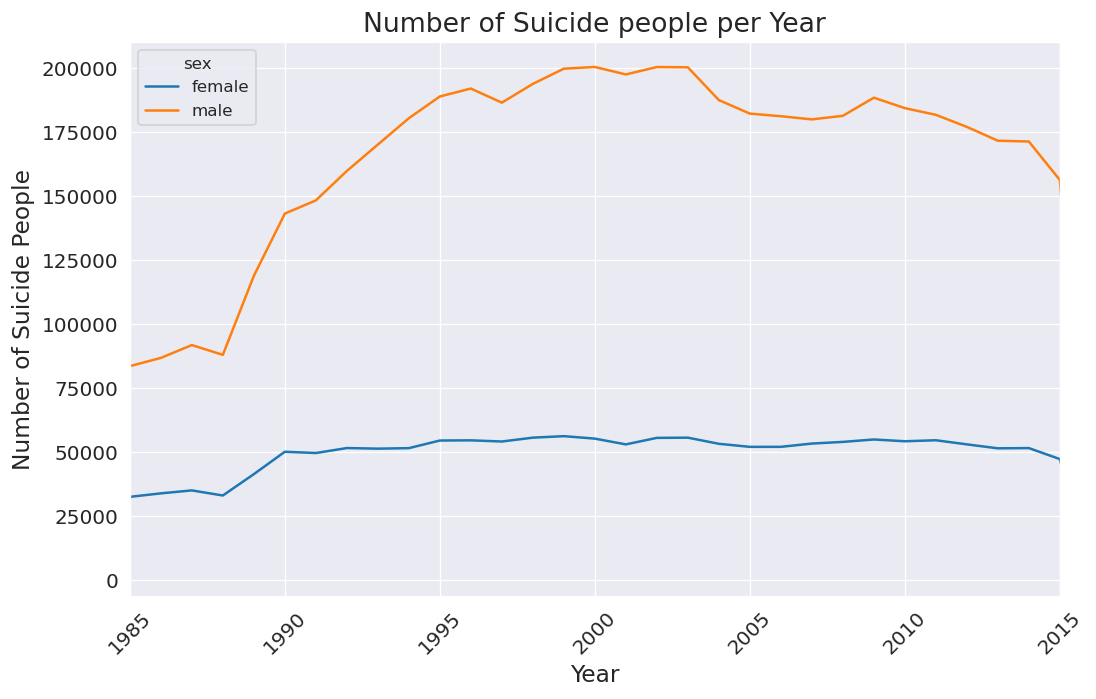

In [12]:
with sns.axes_style('darkgrid'):
    plt.figure(figsize=(10,6), dpi=120)
    plt.title('Number of Suicide people per Year', fontsize=16)
    plt.yticks(fontsize=12)
    plt.xticks(ticks=np.arange(1985, 2020, step=5), 
           fontsize=12, 
           rotation=45)
 
    plt.xlabel('Year', fontsize=14)
    plt.ylabel('Number of Suicide People', fontsize=14)
    plt.xlim(1985, 2015)
    sns.lineplot(data=df_sex_year, x='year', y='suicides_no', hue='sex')


In [13]:
df_age = df.groupby(["year","age"], as_index=False).agg({'suicides_no': pd.Series.sum, 'population':pd.Series.sum})

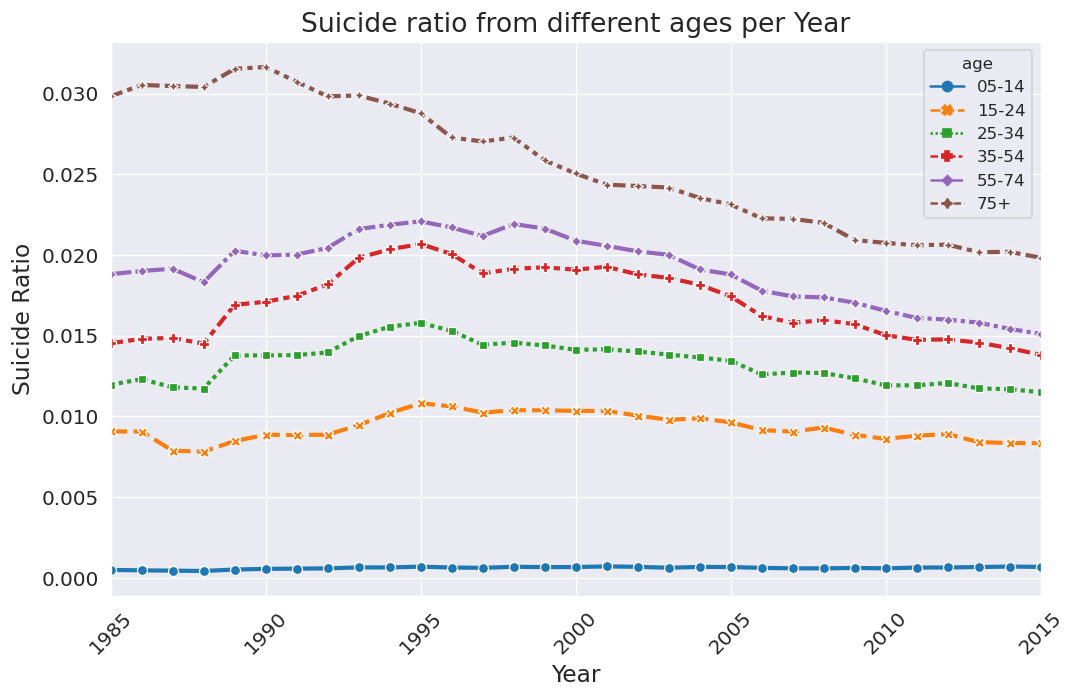

In [14]:
with sns.axes_style('darkgrid'):
    plt.figure(figsize=(10,6), dpi=120)
    plt.title('Suicide ratio from different ages per Year', fontsize=16)
    plt.yticks(fontsize=12)
    plt.xticks(ticks=np.arange(1985, 2020, step=5), 
           fontsize=12, 
           rotation=45)
 
    plt.xlabel('Year', fontsize=14)
    plt.ylabel('Suicide Ratio', fontsize=14)
    plt.xlim(1985, 2015)
    sns.lineplot(data = df_age, x="year", y=df_age.suicides_no*100/df_age.population, hue = "age",
              linewidth = 2.5, style = "age", markers=True)

plt.show()

From the 2 figures above, we see that:
- Men are far more prone to commiting suicide than women, and the suicides number of male are about three times higher than of female.
- Young people, adolescents in particular, are NOT at the greatest risk.

Next, we'll see the suicide rate among different generations.

In [15]:
df_generation = df.groupby(["year","generation"], as_index=False).agg({'suicides_no': pd.Series.sum, 'population':pd.Series.sum})

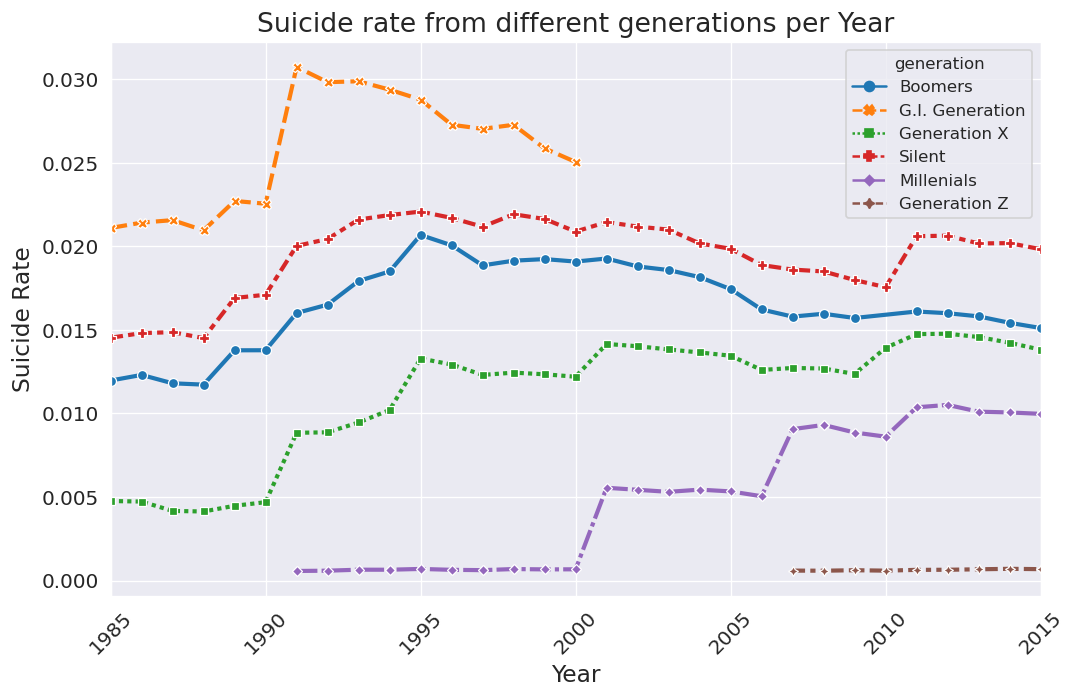

In [16]:
with sns.axes_style('darkgrid'):
    plt.figure(figsize=(10,6), dpi=120)
    plt.title('Suicide rate from different generations per Year', fontsize=16)
    plt.yticks(fontsize=12)
    plt.xticks(ticks=np.arange(1985, 2020, step=5), 
           fontsize=12, 
           rotation=45)
 
    plt.xlabel('Year', fontsize=14)
    plt.ylabel('Suicide Rate', fontsize=14)
    plt.xlim(1985, 2015)
    sns.lineplot(data = df_generation, x="year", y=df_generation.suicides_no*100/df_generation.population, hue = "generation",
              linewidth = 2.5, style = "generation", markers=True)

plt.show()

The G.I. generation, also known as the WW2 generation, had the highest suicide rate before 2000. This generation faced economic and social turmoil during the worldwide Great Depression and the aftermath of WW2. It is possible that these factors contributed to the high suicide rate of this generation. On the other hand, the Silent generation after 2000 did not experience such high rates of suicide. However, the suicide rates of Generation X and Millennials have been increasing steadily. 

Notably, the suicide rate tends to spike when individuals in these generations reach the age of 20 or over. This suggests that young people may be more vulnerable to suicide when they become independent from their parents. Therefore, having a supportive family environment may be beneficial in reducing suicide rates.

In [17]:
df_country = df.groupby("country", as_index=False).agg({"suicides_no": pd.Series.sum})
country_name = list(df_country.country)
len(country_name)

101

In [18]:
countries = {}
for country in pycountry.countries:
    countries[country.name] = country.alpha_3

In [19]:
country_not_in_list = [i for i in country_name if i not in countries.keys()]
country_not_in_list

['Czech Republic',
 'Macau',
 'Republic of Korea',
 'Saint Vincent and Grenadines']

In [20]:
country_replace_list = ['Czechia', 'Macao', 'Korea, Republic of', 'Saint Vincent and the Grenadines']
for i in range(len(country_not_in_list)):
    df.replace(country_not_in_list[i], country_replace_list[i], inplace = True)

In [21]:
# calcuate the suicide rate for each year, and then take the average of number as suicide rate

df_suino = df.groupby(["country","year"]).agg({"suicides_no": pd.Series.sum})
df_sum = df_suino.sort_index(ascending=True) * 100

df_pop = df.groupby(["country","year"]).agg({"population": pd.Series.sum})

df_total = df_sum.suicides_no / df_pop.population
df_total.tail(10)

country     year
Uzbekistan  2002   0.0070
            2003   0.0062
            2004   0.0054
            2005   0.0052
            2009   0.0055
            2010   0.0057
            2011   0.0063
            2012   0.0070
            2013   0.0073
            2014   0.0077
dtype: float64

In [22]:
country_dict={}
for country in df_total.index.get_level_values(0):
    if country not in country_dict.keys():
        country_dict[country] = df_total[country].mean()
        
    else:
        pass

tup = list(country_dict.items())
tup.sort(key= lambda pair:pair[1], reverse = True)

country_list = [a[0] for a in tup]
country_suicide = [a[1] for a in tup]

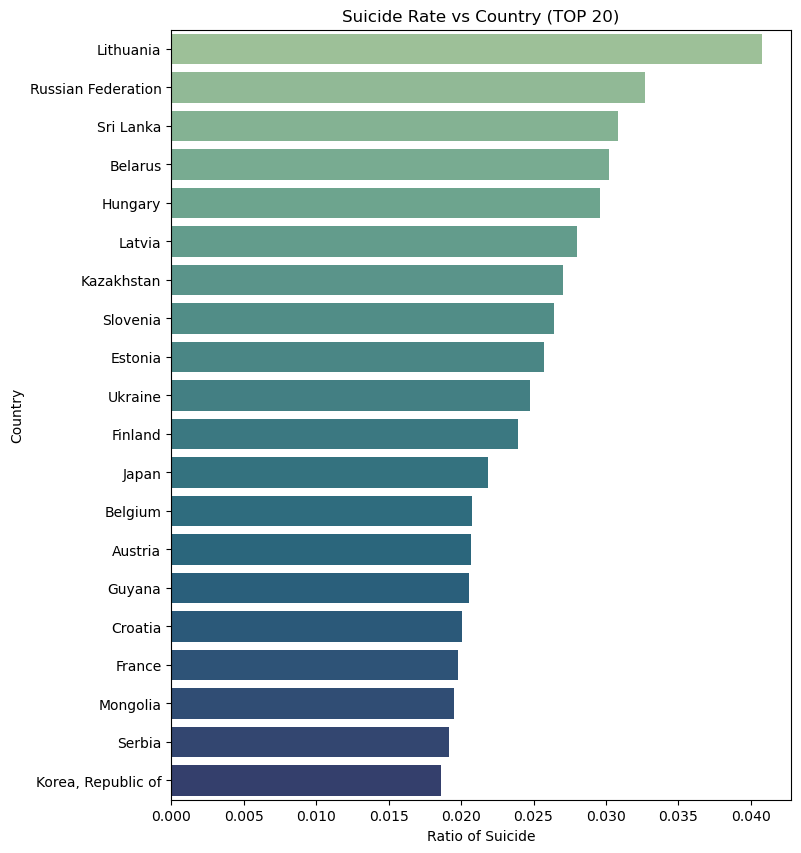

In [23]:
plt.figure(figsize=(8,10))
sns.barplot(x=country_suicide[:20],y=country_list[:20], palette="crest")
plt.xlabel("Ratio of Suicide")
plt.ylabel("Country")
plt.title("Suicide Rate vs Country (TOP 20)")
plt.show()

## Use a Choropleth Map to Show the Ratio of Suicides by Country

In [24]:
# Replace the keys of dictionary with ISO alpha3 country code
country_dict = dict()
for idx in range(len(country_list)):
    country_dict[countries[country_list[idx]]] = country_suicide[idx]

In [25]:
# Define a new dataframe. The columns are country code and suicide rate.
new_country_dict = {}
new_country_dict["iso_a3"] = list(country_dict.keys())
new_country_dict["suicide_rate"] = list(country_dict.values())
new_country_df = pd.DataFrame(new_country_dict)
new_country_df.head()

,iso_a3,suicide_rate
0,LTU,0.0407
1,RUS,0.0327
2,LKA,0.0308
3,BLR,0.0302
4,HUN,0.0296


In [26]:
# Use geopandas library to get information of countries, including coordinate.
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
cities = geopandas.read_file(geopandas.datasets.get_path('naturalearth_cities'))
world.head()

,pop_est,continent,name,iso_a3,gdp_md_est,geometry
0,920938,Oceania,Fiji,FJI,"8,374.0000","MULTIPOLYGON (((180.00000 -16.06713, 180.00000..."
1,53950935,Africa,Tanzania,TZA,"150,600.0000","POLYGON ((33.90371 -0.95000, 34.07262 -1.05982..."
2,603253,Africa,W. Sahara,ESH,906.5000,"POLYGON ((-8.66559 27.65643, -8.66512 27.58948..."
3,35623680,North America,Canada,CAN,"1,674,000.0000","MULTIPOLYGON (((-122.84000 49.00000, -122.9742..."
4,326625791,North America,United States of America,USA,"18,560,000.0000","MULTIPOLYGON (((-122.84000 49.00000, -120.0000..."


In [27]:
result = pd.merge(world, new_country_df, on = "iso_a3")
result.head()

,pop_est,continent,name,iso_a3,gdp_md_est,geometry,suicide_rate
0,920938,Oceania,Fiji,FJI,"8,374.0000","MULTIPOLYGON (((180.00000 -16.06713, 180.00000...",0.0037
1,35623680,North America,Canada,CAN,"1,674,000.0000","MULTIPOLYGON (((-122.84000 49.00000, -122.9742...",0.0131
2,326625791,North America,United States of America,USA,"18,560,000.0000","MULTIPOLYGON (((-122.84000 49.00000, -120.0000...",0.0128
3,18556698,Asia,Kazakhstan,KAZ,"460,700.0000","POLYGON ((87.35997 49.21498, 86.59878 48.54918...",0.0270
4,29748859,Asia,Uzbekistan,UZB,"202,300.0000","POLYGON ((55.96819 41.30864, 55.92892 44.99586...",0.0072


In [28]:
# method 1: ploty choropleth
world_map = px.choropleth(result,
                          locations='iso_a3',
                          color='suicide_rate', 
                          hover_name='name', 
                          color_continuous_scale=px.colors.sequential.matter)
 
world_map.update_layout(coloraxis_showscale=True,)
 
world_map.show()

# method 2: matplotlib
# ax = result.plot()
# ax.set_title("world suicide rate")
# result.plot(column='suicide_rate', ax = ax, legend=True)

Seven out of the top ten countries with the highest suicide rates were located in Eastern Europe and Russia, all of which were former Soviet Union countries. Japan and Korea were also among the high-suicide-rate countries. The disintegration of the Soviet Union may have played a role in the high suicide rates in these countries.

Therefore, let's check the suicide rate year by year.

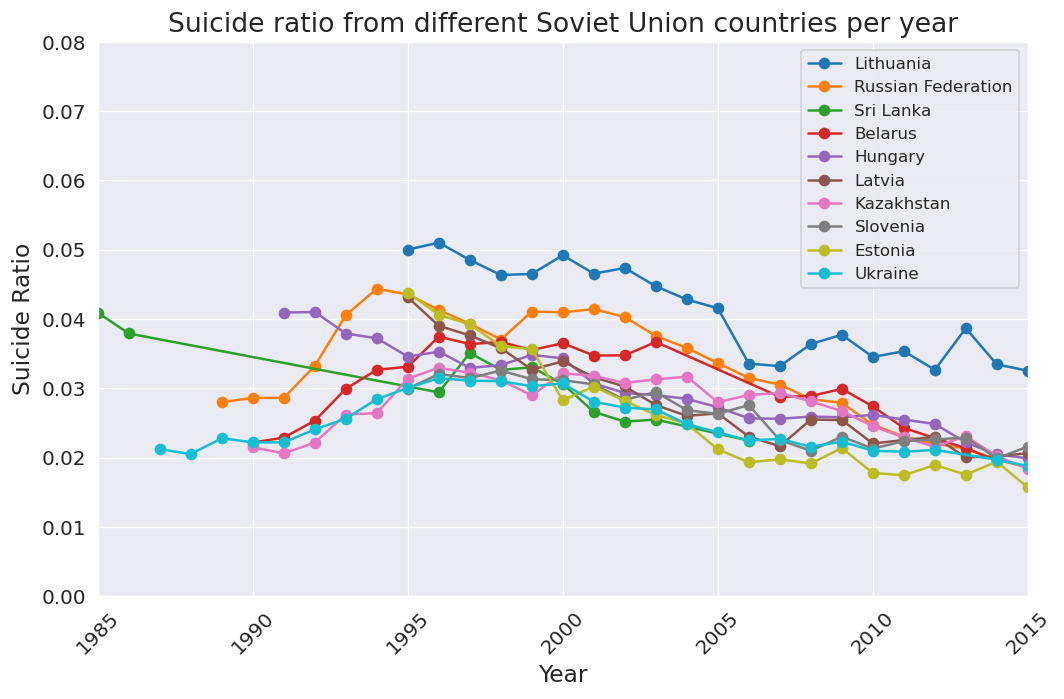

In [29]:
with sns.axes_style('darkgrid'):
    plt.figure(figsize=(10,6), dpi=120)
    plt.title('Suicide ratio from different Soviet Union countries per year', fontsize=16)
    plt.yticks(fontsize=12)
    plt.xticks(ticks=np.arange(1985, 2020, step=5), fontsize=12, rotation=45)

    plt.xlabel('Year', fontsize=14)
    plt.ylabel('Suicide Ratio', fontsize=14)
    plt.xlim(1985, 2015)
    plt.ylim(0, 0.08)

    for country in country_list[:10]:
        plt.plot(df_total[country].index,df_total[country].values, label=country, marker="o")

    plt.legend()
    plt.show()

Some of the top 10 countries' suicide rates have significantly increased since 1990, while rates in other countries remained continuously high from 1990 to 2000. One of the main contributors to this tendency may have been the former Soviet Union countries' transformation to democratic capitalism. There is still no agreement on the most important explanation behind the mortality issue in these countries, despite the fact that many research have been done to explain the rise in mortality rates, including the prevalence of alcoholism, economic difficulty, and despair. To clarify this matter, more investigation is required.

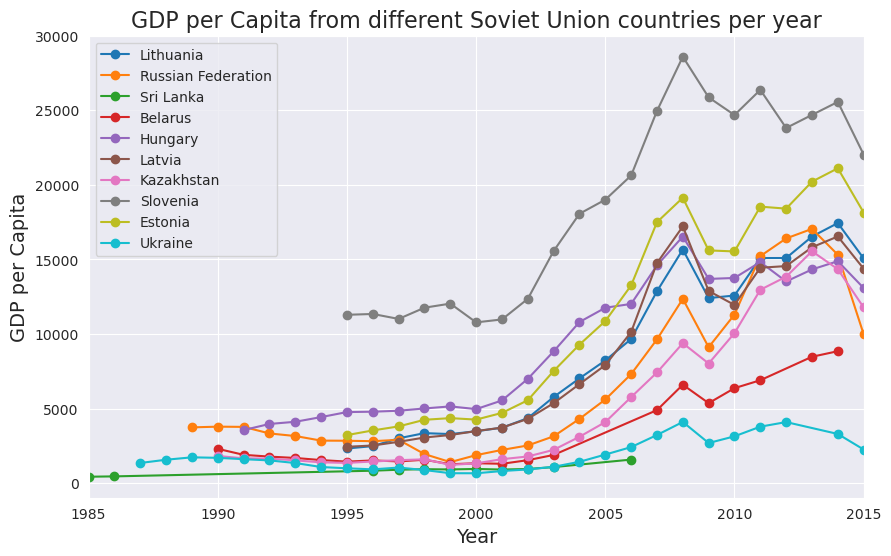

In [30]:
df_gdp = df.groupby(["country","year"]).gdp_per_capita.mean()

with sns.axes_style('darkgrid'):
    plt.figure(figsize = (10,6))
    for country in country_list[:10]:
        plt.plot(df_gdp[country].index,df_gdp[country].values, label=country, marker="o")
    plt.title('GDP per Capita from different Soviet Union countries per year', fontsize=16)
    plt.xlabel("Year", fontsize=14)
    plt.ylabel("GDP per Capita", fontsize=14)
    plt.xlim(1985, 2015)
    plt.legend()
    plt.show()

This image demonstrates that there was no upward trend in the GDP per capita between 1990 and 2000. In other words, the economic situation remained consistent. Then the GDP of all nations began to increase. 

We also know that the financial crisis caused the overall GDP per capita to decline in 2008.  These ratios were still superior to those prior to 2000, though. We present the regression plot of the two parameters to illustrate the relationship between the suicide rate and GDP per capita.

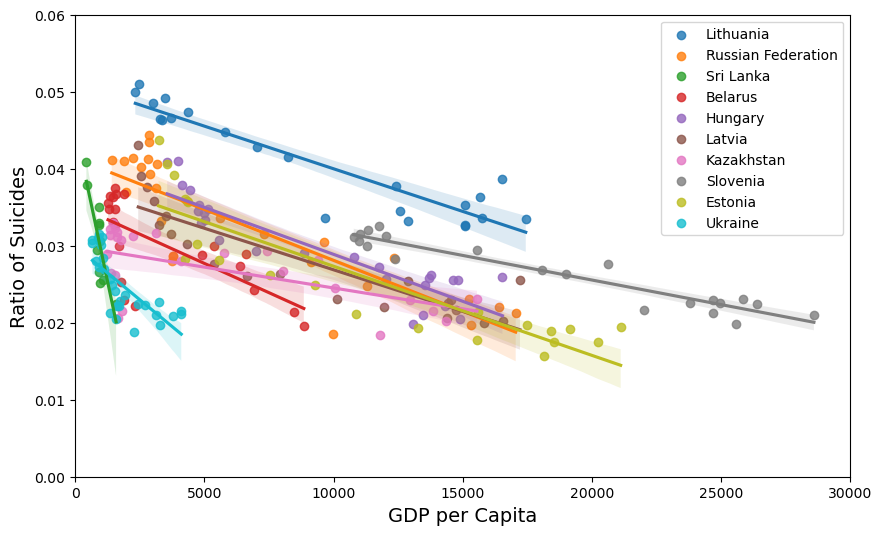

In [31]:
plt.figure(figsize = (10,6))
for country in country_list[:10]:
    sns.regplot(x=df_gdp[country].values, y=df_total[country].values, label = country)
plt.xlabel("GDP per Capita", fontsize=14)
plt.ylabel("Ratio of Suicides", fontsize=14)
plt.ylim(0,0.06)
plt.xlim(0)
plt.legend()
plt.show()

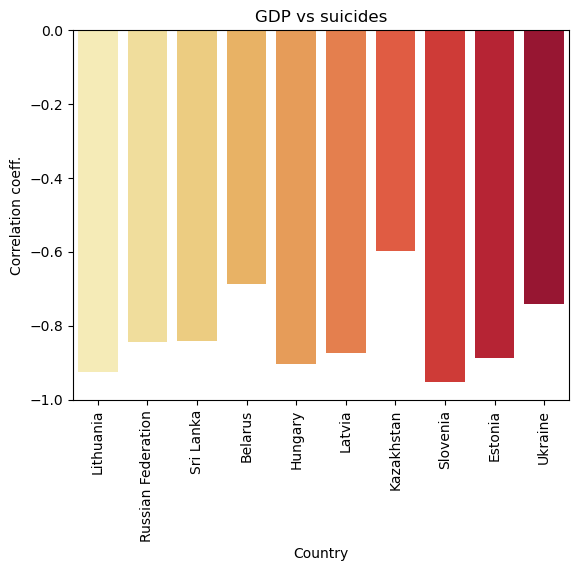

In [32]:
corr_eff = {}
for country in country_list[:10]:
    slope, intercept, r_value, p_value, std_err = stats.linregress(df_gdp[country].values,df_total[country].values)
    corr_eff[country] = float(r_value)
    
sns.barplot(x=list(corr_eff.keys()), y=list(corr_eff.values()), palette = "YlOrRd")
plt.xticks(rotation = 90)
plt.xlabel("Country")
plt.ylabel("Correlation coeff.")
plt.title("GDP vs suicides")
plt.show()

As we can see from the graph above, the suicide rate is highly correlated to the gdp_per_capita of top10 countries. 

Next, investigate whether this trend is shared by other countries. 

/opt/conda/lib/python3.7/site-packages/scipy/stats/_stats_mstats_common.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/opt/conda/lib/python3.7/site-packages/scipy/stats/_stats_mstats_common.py:184: RuntimeWarning:

invalid value encountered in sqrt

/opt/conda/lib/python3.7/site-packages/scipy/stats/_stats_mstats_common.py:187: RuntimeWarning:

invalid value encountered in double_scalars



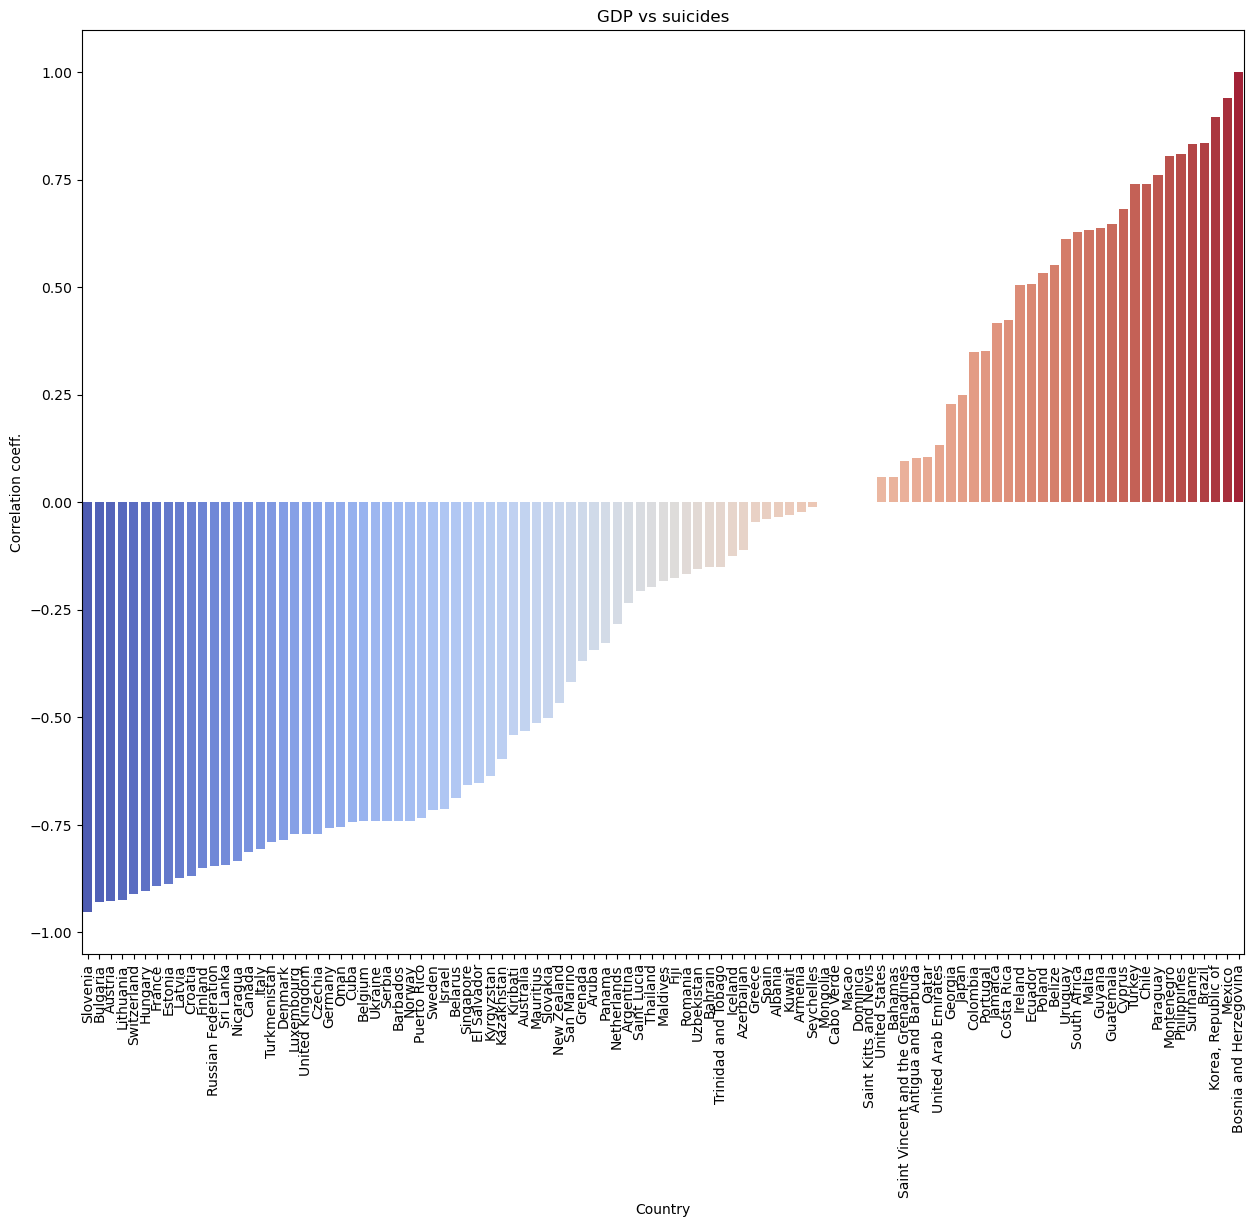

In [33]:
corr_eff = {}
p_value_eff = {}
for country in country_list[:]:
    slope, intercept, r_value, p_value, std_err = stats.linregress(df_gdp[country].values, df_total[country].values)
    corr_eff[country] = float(r_value)
    p_value_eff[country] = float(p_value)

gdp_tup = list(corr_eff.items())
gdp_tup.sort(key= lambda pair:pair[1], reverse = False)
dgp_relation = {a[0]:a[1] for a in gdp_tup}

plt.figure(figsize=(15,12))
sns.barplot(x=list(dgp_relation.keys()), y=list(dgp_relation.values()), palette = "coolwarm")
plt.xticks(rotation = 90)
plt.xlabel("Country")
plt.ylabel("Correlation coeff.")
plt.title("GDP vs suicides")
plt.show()

Calculate the number of nations with correlation coefficients below -0.6 and higher than 0.6 . 

In [34]:
high_relation_gdp = {a:b for a,b in dgp_relation.items() if b <= -0.6}
print(len(high_relation_gdp))
high_relation_gdp

36


{'Slovenia': -0.9529455791278115,
 'Bulgaria': -0.9287679102475701,
 'Austria': -0.9259200512084546,
 'Lithuania': -0.9239757987267332,
 'Switzerland': -0.9109503853299822,
 'Hungary': -0.9040354533627301,
 'France': -0.891033016219988,
 'Estonia': -0.8871441228139314,
 'Latvia': -0.8730699831833395,
 'Croatia': -0.8688905854455011,
 'Finland': -0.8510603475107353,
 'Russian Federation': -0.8447320241371793,
 'Sri Lanka': -0.8423723520534465,
 'Nicaragua': -0.8339461195785591,
 'Canada': -0.8137269827924933,
 'Italy': -0.8058989652804354,
 'Turkmenistan': -0.789798470389873,
 'Denmark': -0.785030750255649,
 'Luxembourg': -0.7712677174711061,
 'United Kingdom': -0.7709229981372079,
 'Czechia': -0.7706689026781656,
 'Germany': -0.7567584036061585,
 'Oman': -0.7547353920453065,
 'Cuba': -0.7437036777206897,
 'Belgium': -0.7416790406841788,
 'Ukraine': -0.7413562367777868,
 'Serbia': -0.7411928190991895,
 'Barbados': -0.7409526707249006,
 'Norway': -0.7406431335510837,
 'Puerto Rico': -0.7

In [35]:
positive_relation_gdp = {a:b for a,b in corr_eff.items() if b > 0.6}
positive_relation_tup = list(positive_relation_gdp.items())
positive_relation_tup.sort(key= lambda pair:pair[1], reverse = True)
positive_relation = {a[0]:a[1] for a in positive_relation_tup}
print(len(positive_relation))
positive_relation

16


{'Bosnia and Herzegovina': 0.9999999999999999,
 'Mexico': 0.9392731898535472,
 'Korea, Republic of': 0.8967892885653613,
 'Brazil': 0.8356111067311864,
 'Suriname': 0.8333078326024657,
 'Philippines': 0.8099497394094539,
 'Montenegro': 0.8042382321252367,
 'Paraguay': 0.7599968993976424,
 'Chile': 0.7412265208253951,
 'Turkey': 0.7398789818429371,
 'Cyprus': 0.6812947745988278,
 'Guatemala': 0.6460477591267608,
 'Guyana': 0.6379567025207803,
 'Malta': 0.6334189190517482,
 'South Africa': 0.6287573335302014,
 'Uruguay': 0.61206046817105}

About one third countries have high relationship with gdp_per_capita. We can say that gdp is another reason of high suicide rate.

While suicide rates are often negatively correlated with gdp per capita in many nations, this is not always the case. There are still certain nations, nevertheless, where GDP per capita is positively correlated with suicide rate.

Let's take a look at suicide rate and gdp_per_capita of these countries.

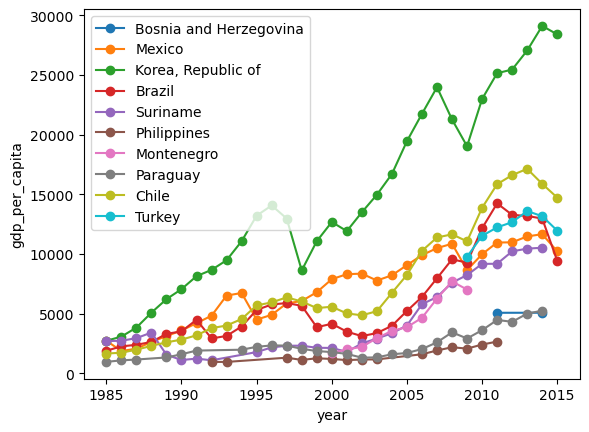

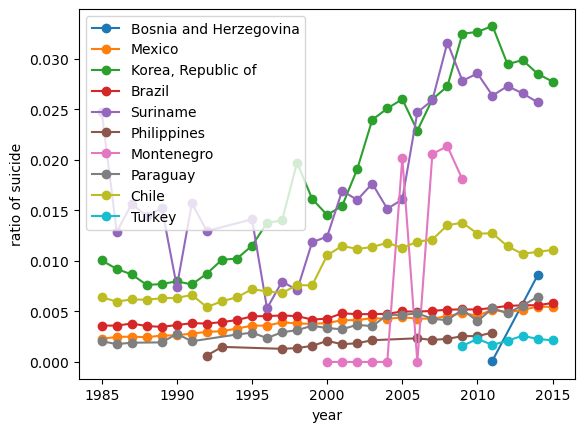

In [36]:
city_list = list({a:b for a,b in positive_relation.items()})
for country in city_list[:10]:
    plt.plot(df_gdp[country].index,df_gdp[country].values, label=country, marker="o")
plt.xlabel("year")
plt.ylabel("gdp_per_capita")
plt.legend()
plt.show()

for country in city_list[:10]:
    plt.plot(df_total[country].index,df_total[country].values, label=country, marker="o")
plt.xlabel("year")
plt.ylabel("ratio of suicide")
plt.legend()
plt.show()

It is unusual that both the GDP per capita and suicide rates in Korea are increasing at a rapid pace. This raises the question of whether there are underlying social issues that may be contributing to this trend.

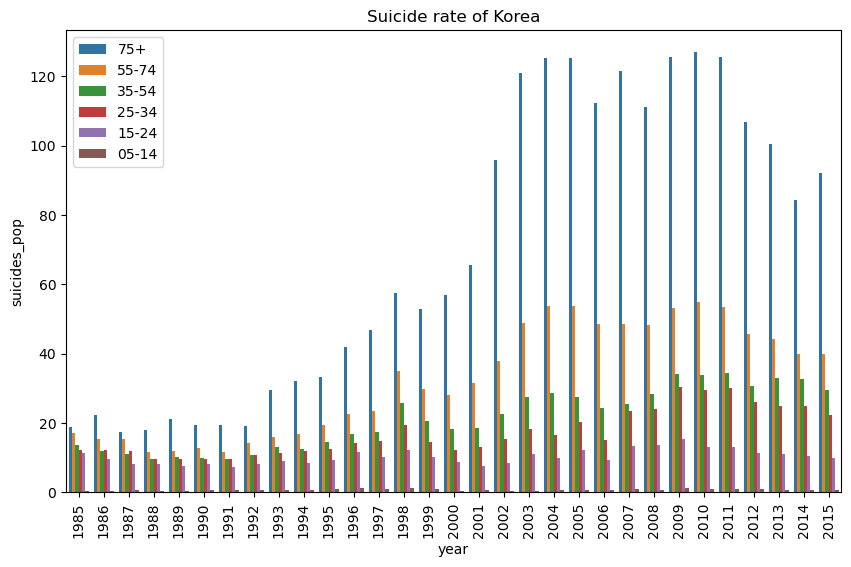

In [37]:
plt.figure(figsize = (10,6))
sns.barplot(x="year", y="suicides_pop", hue="age",
            errorbar=None ,data = (df[df["country"] == "Korea, Republic of"]) )
plt.xticks(rotation = 90)
plt.title("Suicide rate of Korea")
plt.legend()    
plt.show()

The suicide rate among people over 75 years old in Korea has nearly doubled since 2000. This raises questions about whether Korean society is unfriendly towards the elderly or if environmental factors are contributing to the rise in suicides among older people. As previously mentioned, age is a significant factor in the high suicide rates observed in Korea. Therefore, it is essential for the country to establish social welfare programs to support and care for older adults.

Furthermore, the suicide rate among people over 24 years old has been on the rise since 1992, reflecting an increasing burden on Korean society. This burden may be caused by various factors, such as financial pressures, academic stress, family issues, and others. Addressing these underlying issues is crucial to reduce the suicide rates among people in this age group.

Now we examine which countries have high suicide rates that are not necessarily linked to their GDP per capita.

In [38]:
without_relation_gdp = {a:b for a,b in corr_eff.items() if -0.3 < b < 0.3}
no_relation_gdp = [i for i in country_list[:20] if i in without_relation_gdp.keys()]
no_relation_gdp

['Japan', 'Mongolia']

Plot the age structure of Japan.

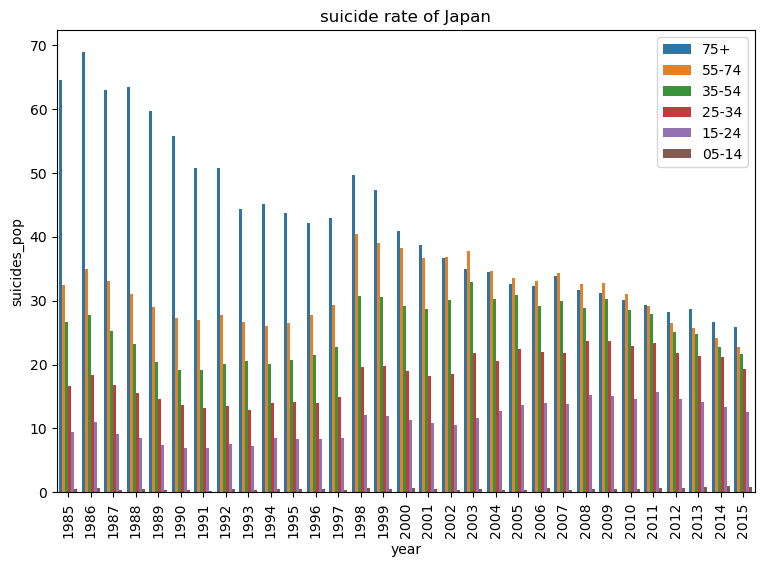

In [39]:
plt.figure(figsize = (9,6))
sns.barplot(x="year", y="suicides_pop", hue="age",
            errorbar=None, data = (df[df["country"] == "Japan"]) )
plt.xticks(rotation = 90)
plt.title("suicide rate of Japan" )
plt.legend()    
plt.show()

Although the suicide rate of the elderly has improved, the rate of young people is still not low. This shows that the social pressure haven't been relieved.

## Conclusion
In this study, we see several factors that are known to be related to suicide rates. One of the most significant factors is the national GDP per capita. Studies have shown a strong correlation between the suicide rate and the overall GDP of a country, indicating that higher national wealth is associated with a lower suicide rate.

Another significant factor is age, with the suicide rate among elderly people generally higher than among other age groups. As such, it is important for younger generations to pay attention to the needs and wellbeing of the elderly. Adequate welfare provisions for the elderly can also impact suicide rates.

Lastly, social pressure is also known to be a significant factor in suicide rates. A healthy and supportive society can help citizens feel safe and satisfied, reducing the likelihood of suicide. Therefore, it is crucial for countries to address the issue of social pressure and create a supportive environment for their citizens. Ultimately, the goal is not only to reduce suicide rates but to create a better world for everyone.